# Portfolio optimization

We will obtain the data for a portfolio using Qiskit's data generator.

In [1]:
import random
import datetime
from qiskit_finance.data_providers import *

# For experiments
gen_seed = 42
random.seed(gen_seed)

assets = ["TICKER1", "TICKER2","TICKER3","TICKER4"]
data = RandomDataProvider(tickers=assets,
                 start = datetime.datetime(2016, 1, 1),
                 end = datetime.datetime(2017, 1, 1),
                 seed = 1)
data.run()

In [3]:
mu = data.get_mean_vector() # Returns vector
sigma = data.get_covariance_matrix() # Covariance
print(f"Expected average return for each asset: {mu}")
print(f"Asset covariance: {sigma}")

Expected average return for each asset: [77.60417796 29.71772711 19.06733564 32.14568747]
Asset covariance: [[162.22030329  16.96480901  53.33392587 -61.19096975]
 [ 16.96480901  69.33332072  16.523284    10.15842664]
 [ 53.33392587  16.523284    43.90334576 -11.43885741]
 [-61.19096975  10.15842664 -11.43885741  46.42412482]]


# QUBO

\begin{equation}
\begin{split}
\min_{x_{i}\in{\{0,1\}}} \;\; & \theta_{1}\sum_{i=1}^{n}-x_{i}\text{E}(R_{i}) \\
\;\;  +\;&\theta_{2}\sum_{i,j=1}^{n}x_{i}x_{j}\text{Cov}(R_{i},R_{j})  \\
 +\;&\theta_{3}\left(\sum_{i=1}^{n}x_{i}B_{i}-B\right)^{2}
\end{split}
\end{equation}


The parameters $0\leq\theta_{1},\theta_{2},\theta_{3}<\infty$ represent the relative importance of each term to the decision maker, and she is free to change these parameters to best reflect that (we'll give some examples of this in the next paragraph).  The first term in the objective function represents the expected return, i.e. the gain.  The second term represents the variance in the return, i.e. the risk.  Finally, the last term penalizes our decision maker when the sum of all $B_i$ is lower than the total available budget $B$.

The parameters $\theta_{1},\theta_{2}$, and $\theta_{3}$ represent the relative importance to the decision maker of each term, and she is free to change these parameters to best reflect that.  For instance, in the extreme case that the decision maker does not care about risk, but only about the possible gains, then she may set $\theta_{1}\gg\theta_{2}$.  On the other hand, if she is very risk averse she could set $\theta_{2}\gg\theta_{1}$. Finally,  $\theta_{3}$ can be adjusted to modulate the penalty of allocations which involve investing a total amount that is less than $B$.

In [4]:
from qiskit_finance.applications.optimization import PortfolioOptimization

num_assets = len(assets)

q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
print(qp)

minimize 81.11015164275673*x_0^2 + 16.964809008439097*x_0*x_1 + 53.33392586906674*x_0*x_2 - 61.19096975168505*x_0*x_3 + 34.66666036230388*x_1^2 + 16.5232840046043*x_1*x_2 + 10.158426637281433*x_1*x_3 + 21.951672879835687*x_2^2 - 11.438857414391833*x_2*x_3 + 23.21206241134793*x_3^2 - 77.60417795756565*x_0 - 29.717727105815644*x_1 - 19.067335643484537*x_2 - 32.14568746752564*x_3 (4 variables, 1 constraints, 'Portfolio optimization')


In [5]:
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)
result

<MinimumEigenOptimizationResult: fval=-66.61862112267167, x_0=1.0, x_1=0.0, x_2=0.0, x_3=1.0, status=SUCCESS>

In [6]:
import numpy as np

# Allowable asset allocation quantities (B_i)
min_cost=np.min(mu)
max_cost=np.max(mu)

# Compute a random cost per asset and a total budget
possible_costs=list(range(int(min_cost),int(max_cost)+1))
costs=[random.choice(possible_costs) for _ in range(len(assets))]
budget=sum(costs)/2
print("Allowable asset allocation quantities: {0}".format(costs))
print("Budget to be expent: {0}".format(budget))

Allowable asset allocation quantities: [59, 26, 20, 66]
Budget to be expent: 85.5


In [7]:
import cvxpy as cp

# Our solution variable
x_val = cp.Variable(len(mu), boolean=True)
gamma = cp.Parameter(nonneg=True)
ret = np.array(mu)@x_val
risk = cp.quad_form(x_val, sigma)
e_costs = np.array(costs)@x_val

# Constraints
cons = [cp.sum(x_val) >= 0, cp.sum(e_costs) <= budget, x_val >= 0]

# Objective function
obj = cp.Minimize(- ret + gamma*risk)

# Problem
prob = cp.Problem(obj, cons)

In [8]:
%%time

gamma.value = 0.03 # This is related to the risk penalty below \theta2
prob.solve(solver='ECOS_BB')

CPU times: user 70.4 ms, sys: 46.4 ms, total: 117 ms
Wall time: 76.7 ms


-99.35740783826851

In [9]:
np.round(x_val.value,1)

array([1., 1., 0., 0.])

In [10]:
e_cost = np.round(np.sum(np.multiply(costs,x_val.value)),2)
print(f'The effective cost of this investment is {e_cost} for the budget limit of {budget}')

The effective cost of this investment is 85.0 for the budget limit of 85.5


# D-Wave

In [11]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import FixedEmbeddingComposite
import minorminer
import dimod

# Instanciate Sampler
dwave_sampler = DWaveSampler()

# DWave sampler parameters
amode = 'histogram'
allowed_ta = dwave_sampler.properties['annealing_time_range'] #microsecond
num_reads=100

In [12]:
from utils import get_problem

qubo, offset = get_problem(mu, sigma)
# Construct a problem
bqm = dimod.BinaryQuadraticModel(qubo, dimod.BINARY)

# Get the edge list
target_edgelist = dwave_sampler.edgelist

# And source edge list on the BQM quadratic model
source_edgelist = list(bqm.quadratic)

# Find the embeding
embedding = minorminer.find_embedding(source_edgelist, target_edgelist)
sampler = FixedEmbeddingComposite(dwave_sampler, embedding)

In [13]:
ta = 10 # microseconds
num_reads = 100
response = sampler.sample_qubo(qubo, num_reads=num_reads, annealing_time=ta, answer_mode='histogram')
    
data = response.to_pandas_dataframe()
data["probability"] = data["num_occurrences"]/num_reads
cols = []
for i in range(num_assets):
    cols += [f'x[{i}]']
data['solution'] = data[cols].astype('str').agg(''.join, axis=1)
data

,x[0],x[1],x[2],x[3],chain_break_fraction,energy,num_occurrences,probability,solution
0,1,1,0,0,0.0,-37.035715,32,0.32,1100
1,0,0,1,1,0.0,-36.840382,15,0.15,0011
2,1,0,1,0,0.0,-36.663356,19,0.19,1010
3,0,1,0,1,0.0,-36.618842,16,0.16,0101
4,1,1,1,0,0.0,-35.021480,2,0.02,1110
5,0,0,0,1,0.0,-34.810728,7,0.07,0001
6,1,0,0,0,0.0,-33.428021,6,0.06,1000
7,0,1,1,1,0.0,-33.398925,3,0.03,0111


In [14]:
sol = [1,1,0,0]

e_cost = np.round(np.sum(np.multiply(costs,sol)),2)
print(f'The effective cost of this investment is {e_cost} for the budget limit of {budget}')

The effective cost of this investment is 85 for the budget limit of 85.5


In [15]:
print(f'Annealing time range {allowed_ta}')

Annealing time range [0.5, 2000.0]


In [16]:
print(f'Steepest curve segment {min(allowed_ta)} microseconds')

Steepest curve segment 0.5 microseconds


We can change the annealing function so that it provides a better success probability:

![annealingfunc](../assets/annealing_trajectories.png)

In [17]:
schedule = [[0.0, 0.0], [1400.0, 0.3], [1500, 1.0]]

anneal_params = dict(anneal_schedule=schedule, answer_mode=amode)
response = sampler.sample_qubo(qubo, num_reads=num_reads, **anneal_params)
    
data = response.to_pandas_dataframe()
data["probability"] = data["num_occurrences"]/num_reads
cols = []
for i in range(num_assets):
    cols += [f'x[{i}]']
data['solution'] = data[cols].astype('str').agg(''.join, axis=1)

data

,x[0],x[1],x[2],x[3],chain_break_fraction,energy,num_occurrences,probability,solution
0,1,1,0,0,0.0,-37.035715,34,0.34,1100
1,0,0,1,1,0.0,-36.840382,17,0.17,0011
2,1,0,1,0,0.0,-36.663356,14,0.14,1010
3,0,1,0,1,0.0,-36.618842,21,0.21,0101
4,1,1,1,0,0.0,-35.021480,6,0.06,1110
5,0,0,0,1,0.0,-34.810728,5,0.05,0001
6,1,0,0,0,0.0,-33.428021,2,0.02,1000
7,0,1,1,1,0.0,-33.398925,1,0.01,0111


# Digital circuits

In [18]:
from utils import get_coeffs, circuit

h,jp = get_coeffs(qubo, offset)
qc = circuit(num_assets, [0.0, 0.0], 1, h, jp)

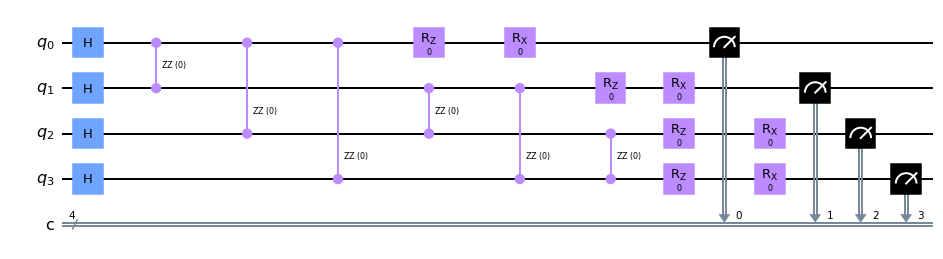

In [20]:
qc.draw('mpl', fold=100)

In [21]:
import numpy as np
from utils import get_expectation
from scipy.optimize import basinhopping
from qiskit import Aer

# execute the quantum circuit
backend = Aer.get_backend('qasm_simulator') # the device to run on

num_layers = 1
num_params = 2
minimizer_kwargs = {"method": "COBYLA"}

params = np.random.rand(num_layers*num_params)
expectation = get_expectation(num_layers, h, jp, backend)
results = basinhopping(expectation, params, minimizer_kwargs=minimizer_kwargs, niter=200)

In [22]:
results

                        fun: -4.075072964005117
 lowest_optimization_result:      fun: -4.075072964005117
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 26
  status: 1
 success: True
       x: array([26.28761889, 11.46169236])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 5517
                        nit: 200
                    success: True
                          x: array([26.28761889, 11.46169236])

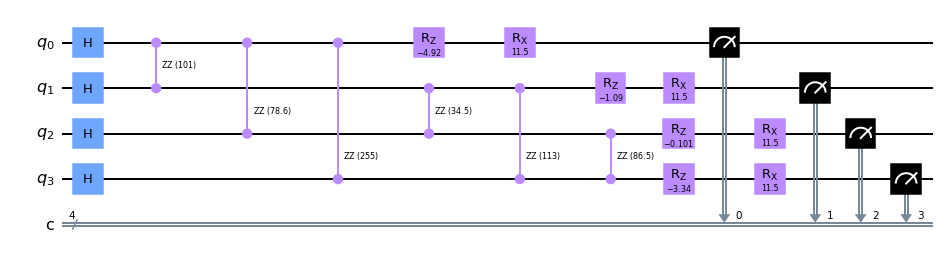

In [23]:
circ = circuit(len(h), results.x, num_layers, h, jp)
circ.draw('mpl', fold=120)

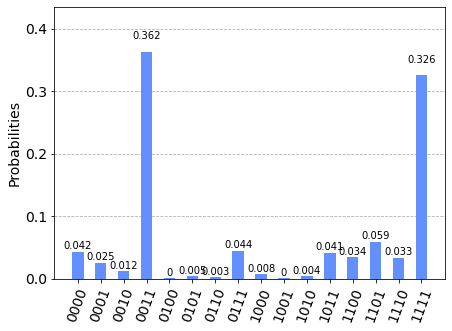

In [24]:
from qiskit.visualization import plot_histogram

counts = backend.run(circ, seed_simulator=10, nshots=500).result().get_counts()
plot_histogram(counts)

In [61]:
from dotenv import load_dotenv
load_dotenv()

import os
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from azure.quantum.qiskit import AzureQuantumProvider

from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = os.environ['RESOURCE'],
    location = "eastus"
)

In [29]:
simulator_backend = provider.get_backend("ionq.simulator")
job = simulator_backend.run(circ, shots=1024)
job_monitor(job)

Job Status: job has successfully run


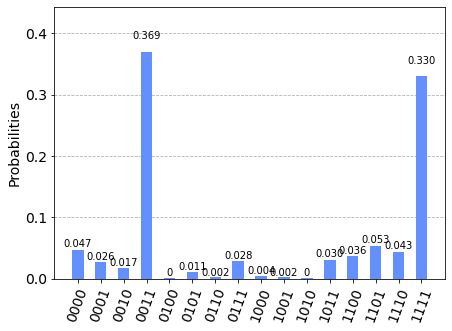

In [30]:
from qiskit.visualization import plot_histogram

result = job.result()
plot_histogram(result.get_counts())

In [63]:
backend = provider.get_backend("ionq.qpu")
cost = backend.estimate_cost(circ, shots=100)

print(f"Estimated cost: {cost.estimated_total}")

Estimated cost: 1.0


In [ ]:
job = backend.run(circ, shots=1024)

In [64]:
job = backend.retrieve_job("734985f5-4b9d-11ed-8a26-2fa811d6f573")

In [65]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

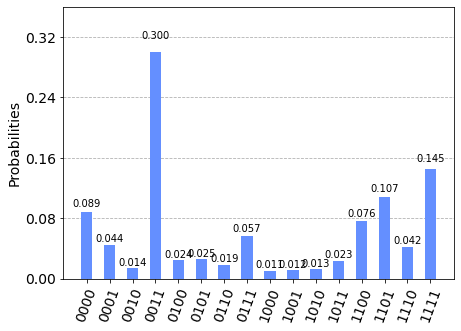

In [66]:
result = job.result()
plot_histogram(result.get_counts())

Of course this effect of noise goes a little bit deeper when we try with device not that well suited for this circuit.

In [ ]:
from qiskit import IBMQ

# IBMQ.save_account(os.environ["TOKEN"])
IBMQ.load_account() # Load account from disk

We could check the systems available within IBM's service: https://quantum-computing.ibm.com/services?services=systems

In this case we will look for a 5 qubit system with less queue time.

In [54]:
from qiskit.providers.ibmq import least_busy

provider = IBMQ.get_provider(hub='ibm-q')
device = least_busy(
    provider.backends(
        filters=lambda x: x.configuration().n_qubits == 5  # 5 qubits
        and not x.configuration().simulator                # Not a simulator
        and x.status().operational == True                 # Operational backend
    )
)

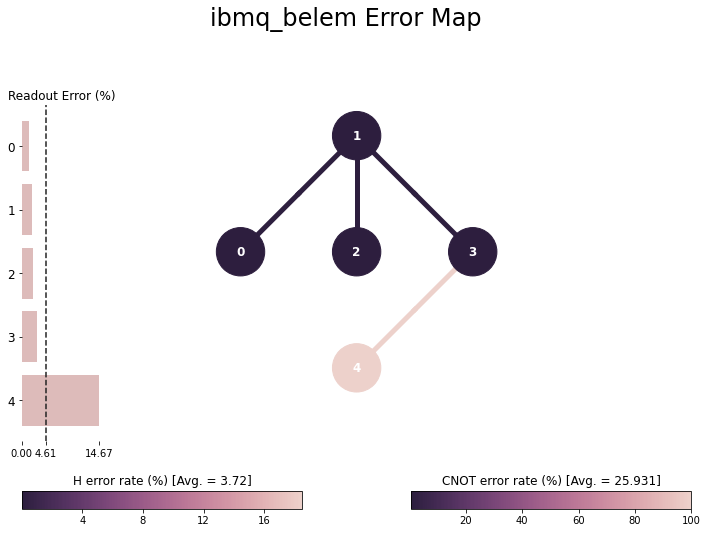

In [55]:
from qiskit.visualization import plot_error_map

plot_error_map(device)

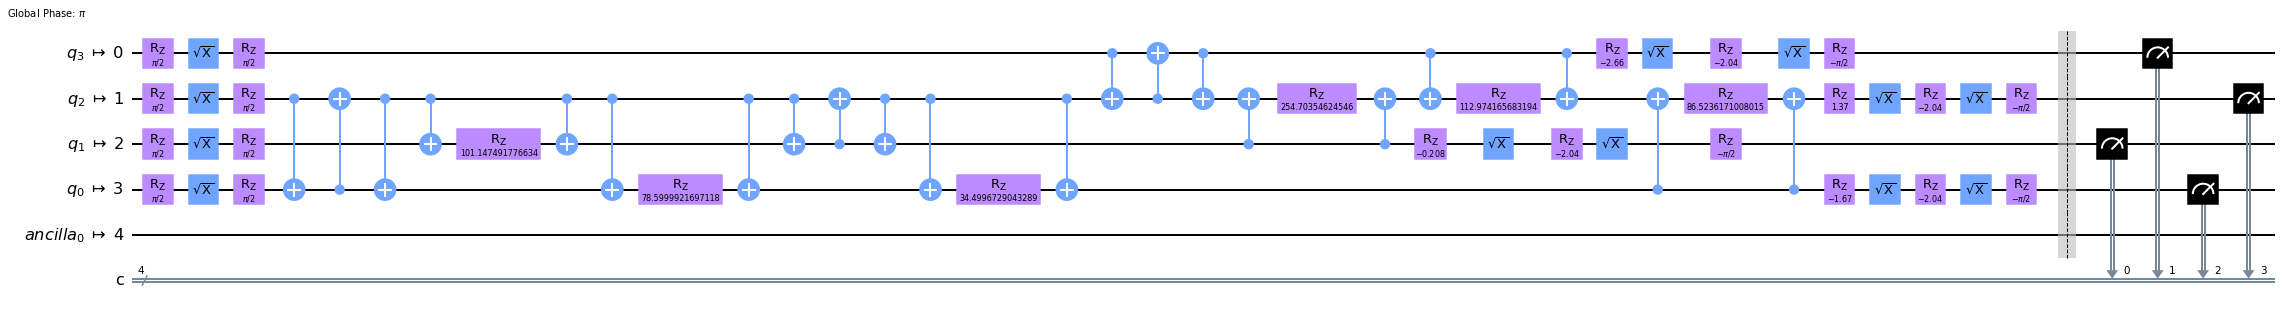

In [58]:
from qiskit import transpile

transpiled_circ = transpile(circ, device) 
transpiled_circ.draw('mpl', fold=120)

In [59]:
job = device.run(transpiled_circ, shots=1000)

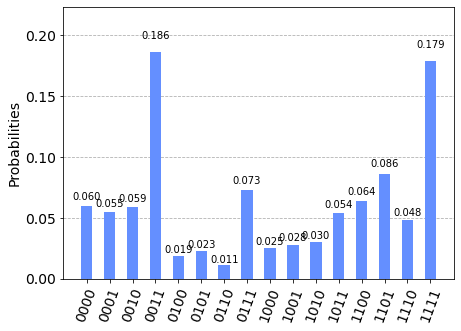

In [60]:
results = job.result()
counts = results.get_counts()
plot_histogram(counts)